<a href="https://colab.research.google.com/github/DrLSimon/Labs_AlexisLechervy/blob/lab1/tp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TP3: Introduction à PyTorch (Réalisation d'un classifieur de panneau de circulation)
============

Introduction au sujet
------

L'objectif de ce sujet est de créer un classifieur de panneau routier. Les images utilisées dans ce TP seront une sous partie de la base German Traffic Sign Recognition Benchmark (GTSRB http://benchmark.ini.rub.de/?section=gtsrb&subsection=news ).

Nous allons réaliser notre classifieur à partir d'un réseau de type ResNet18 (https://arxiv.org/pdf/1512.03385.pdf ) pré-entrainé sur la base ImageNet (http://www.image-net.org/ ). 


**Afin d'avoir un code optimisé, vous éviterez d'utiliser les instructions python3 if, for et while (sauf mention contraire dans les sujets).**

Le code est à écrire en python3 à la suite des questions dans ce fichier. Vous appuierez soit sur le bouton *run cell*, soit sur les touches *Ctrl-Entrée*, à l’intérieur de la zone de saisie, pour lancer l'exécution de vos commandes. Si la commande est en cours d’exécution une étoile apparaît à côté de la zone de saisie de la commande : In [\*]. Une fois le calcul achevé, l'étoile est remplacée par le numéro du run permettant de retrouver par la suite dans quel ordre ont été lancés chaque bloc.

Commencez par importer les librairies nécessaires au TP. Les dernières lignes sont spécifiques à l'usage d'un notebook. Elles permettent d'indiquer que les affichages matplotlib doivent être faits dans le notebook et non dans une fenêtre extérieure. 


In [ ]:
# Import Torch
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

# Import TorchVision
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

# Import numpy et matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Autres
import time
import copy

%matplotlib inline

1 - Lecture de la base de données
------

La gestion de l'accès aux données se fera au travers d'un `torch.utils.data.DataLoader` qui s'occupera notamment du découpage en mini-batch de la base de données. Comme vu en cours, les `DataLoader` utilisent des objets de type `torch.utils.data.TensorDataset` pour accéder aux données. Au lieu de redéfinir une classe `TensorDataset` adaptée à notre problème, nous allons utiliser la classe `torchivision.datasets.ImageFolder` qui permet d'accéder à un dataset composé d'images réparties dans des dossiers. Chaque classe correspondra à une classe différente.

Les images qui ont été mises à votre disposition sont des images couleurs dont les dimensions sont variables avec des ratios différents. Nous allons devoir les pré-traiter pour nous ramener à des images ayant tous la même taille $(224,224)$.

Commencez par créer un objet `transform` qui contiendra les différentes opérations de pré-traitement des données (redimensionnement des images et conversion des images en Tensor PyTorch). Vous utilisez pour cela la fonction `torchivision.transforms.Compose`   et les transformations `torchivision.transforms.Resize` et `torchivision.transforms.ToTensor`. Vous pouvez consulter la documentation de ces fonctions pour plus de détail: https://pytorch.org/docs/stable/torchvision/transforms.html

In [ ]:
print(transform)

Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
)


Créez un objet `gtsrb_data_train` qui permettra au `DataLoader` d'accéder aux images. Pour créer cet objet, vous utiliserez la fonction `torchvision.datasets.ImageFolder` (https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder ) auquel vous passerez le dossier des images d'apprentissage et les transformations précédemment définies.

In [ ]:
print(gtsrb_data_train)

Dataset ImageFolder
    Number of datapoints: 1686
    Root Location: ./GTSRB/Final_Training/Images
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None


Créez un objet `dataloaders` de type `torch.utils.data.DataLoader` qui sera en charge de générer les batchs. 
Vous paramétrez le `DataLoader` pour des batchs de 32 images mélangées aléatoirement. Le nombre de `workers` sera fixé à 4.

Le code suivant permet d'afficher la moyenne des images contenues dans les classes 1 et 2. Il est important de remarquer que l'ordre des dimensions des images est (nbr de canaux,nbr de colonne, nbr de ligne).

Dimension de l'image moyenne: torch.Size([3, 224, 224])


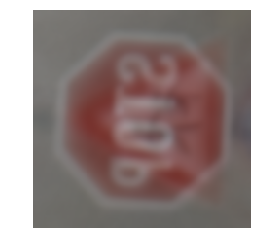

In [ ]:
im_moy = torch.mean(torch.cat([x[(y==1) + (y==2)] for x,y in dataloaders]),0)
print('Dimension de l\'image moyenne:',im_moy.shape)
plt.imshow(torch.transpose(im_moy,0,2))
plt.axis('off')
plt.show()

Affichez les dix premières images de chacune des 4 classes disponibles.

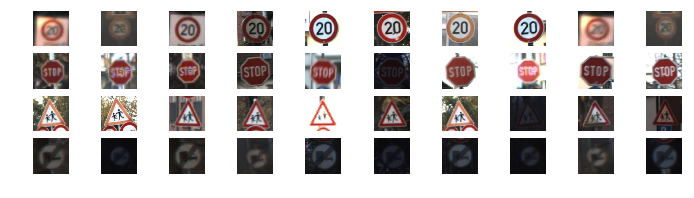

Créez un `DataLoader` pour les images de test et affichez toutes les images. Vous ne ferez pas de mélange aléatoire pour les données de test. 

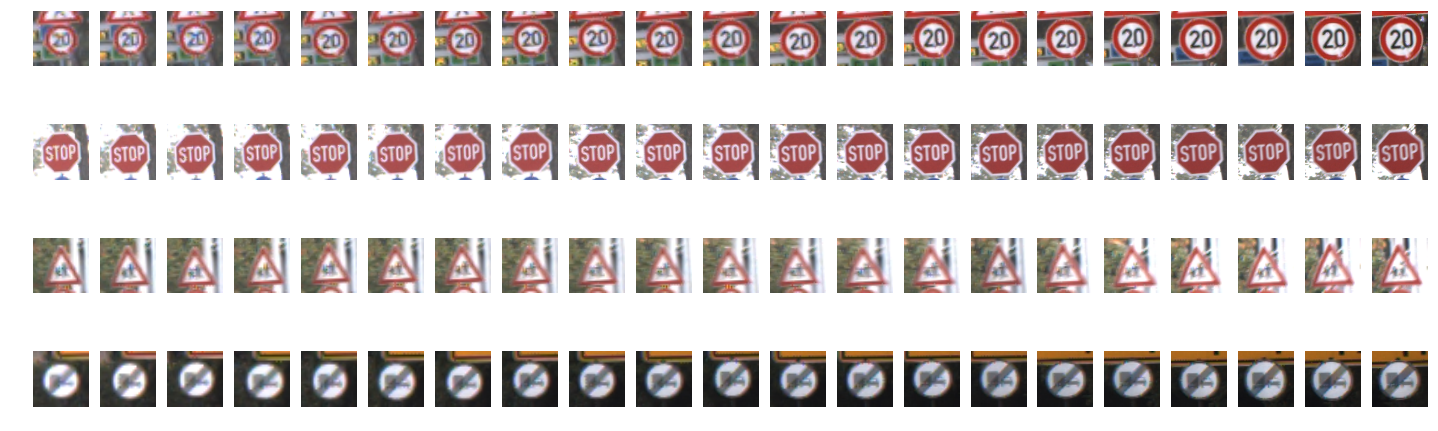

2 - Apprentissage à partir d'un ResNet18 pré-entrainé
------

Le réseau que nous allons utiliser est un ResNet18 (à 18 couches) dont l'architecture est la suivante:  

![Reseau ResNet 18](ResNet18.jpg)

Nous allons utiliser un réseau pré-entrainé sur la base ImageNet. Nous allons supprimer la dernière couche du réseau pré-entrainé et la remplacer par une nouvelle couche entièrement connectée à 4 sorties (une par classe de notre problème). Nous entrainerons uniquement cette nouvelle couche pour limiter les temps de calcul. 

En utilisant `torchvision.models.resnet18` (https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.resnet18 ) récupérez un modèle  ResNet18 avec les poids pré-entrainés sur ImageNet. Vous le placerez dans une variable nommée `resnet18`.

In [ ]:
resnet18 = ?
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Le réseau que vous venez de récupérer correspond à l'implémentation de l'architecture RestNet18 avec une classe héritant de `torch.nn.Module` (pour plus de détail le code est à l'adresse: https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html ). Les différentes parties du réseau ont été principalement regroupées dans 6 attributs:
* conv1,bn1,maxpool,relu: définissant les éléments de la première couche de convolution (en jaune et bleu sur les schémas)
* layer1: les couches de convolutions de taille 64 (en violet sur le schéma)
* layer2: les couches de convolutions de taille 128 (en rouge sur le schéma)
* layer3: les couches de convolutions de taille 256 (en bleu sur le schéma)
* layer4: les couches de convolutions de taille 512 (en vert sur le schéma)
* fc: la couche entièrement connectée finale (en blanc sur le schéma).

Le code suivant permet de récupérer la définition du premier layer et les valeurs des poids de la première couche de convolution: 

In [ ]:
print('Définition du premier layer',resnet18.layer1)
print('Poids de la première couche de convolution:',resnet18.layer1[0].conv1.weight)

Définition du premier layer Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Poids de la première couche de convolution: Parameter containing:
tensor([[[[ 5.7593e-02, -9.5114e-02, -2.0272e-02],
          [-7.4

Nous allons dans cette question afficher les 64 images de sorties de la première couche de convolution (conv1). Pour faire cette question, appliquez uniquement la première couche du réseau sur le premier batch (il suffit de faire de récupérer la couche et de l'appliquer comme une fonction). 

Vous afficherez ensuite uniquement la première image et les 64 images de sortie de la couche `conv1`. Que pouvez-vous dire sur le type de traitement qu'effectuent ces filtres ? 

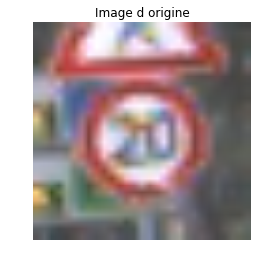

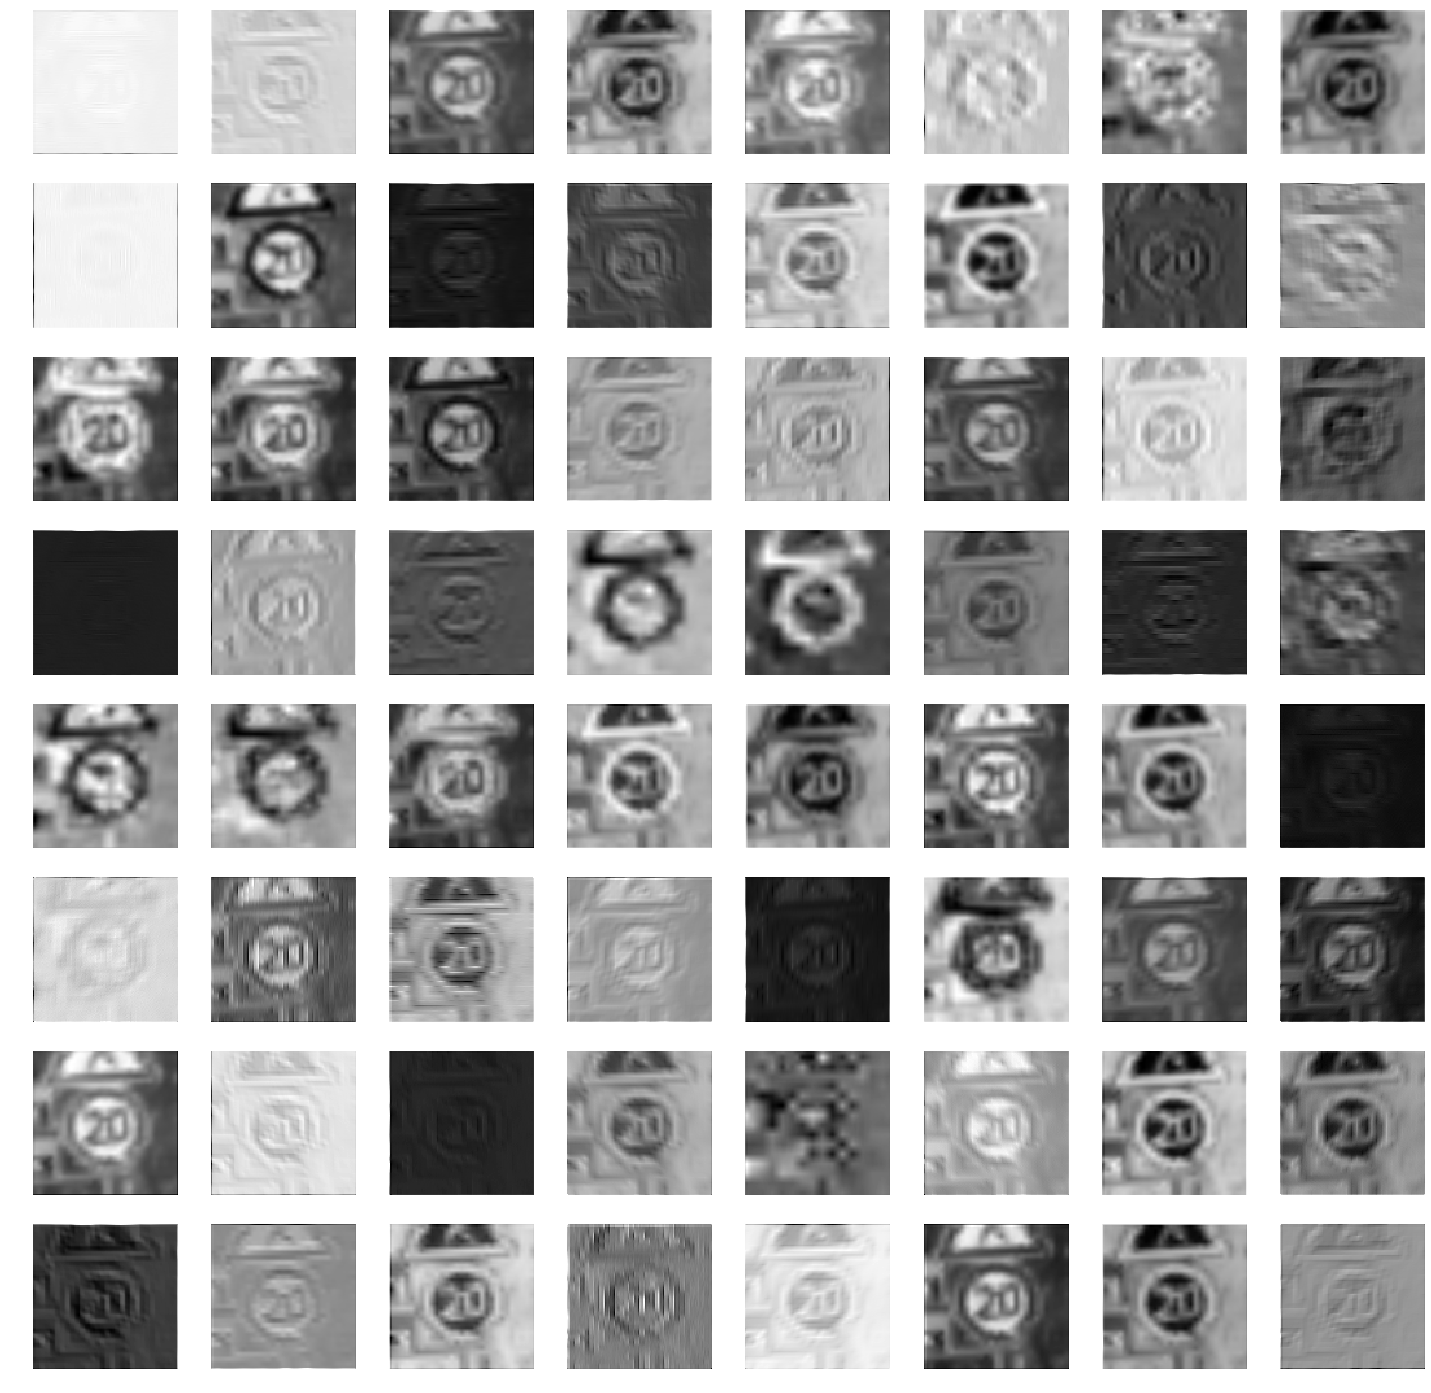

In [ ]:
# récupération des 32 premières images.
im,_=next(iter(dataloaders_test))

#...

Affichez la composition de la couche entièrement connectée finale. Quelle est la taille de la couche de sortie ? Cette valeur est-elle adaptée à notre problème ? 

Dernière couche: Linear(in_features=512, out_features=1000, bias=True)


Redéfinissez cette dernière couche en la remplaçant par une couche linéaire de 4 sorties. Pour cela vous pouvez directement changer redéfinir l'attribut `fc` avec un `=`.

Dernière couche après redéfinition: Linear(in_features=512, out_features=4, bias=True)


Placez les éléments du modèle en carte graphique avec la méthode `to` ou la méthode `cuda`.

In [ ]:
print('Vérification que le réseau est bien en GPU:',next(resnet18.parameters()).device)

Vérification que le réseau est bien en GPU: cuda:0


Le code suivant permet de visualiser les performances du classifieur sur les quatre classes. Pour l'instant nous n'avons pas entrainé la dernière couche du réseau. Il est donc normal que les performances soient mauvaises.

In [ ]:
%%time
class_correct = torch.zeros(4,device=device)
class_total = torch.zeros(4,device=device)

with torch.no_grad():
    # Mode evaluation
    resnet18.eval()
    for images, labels in dataloaders_test:
        # Placement en GPU des données
        images = images.to(device)
        labels_true = labels.to(device)
        # Evaluation des images
        proba_estim = resnet18(images)
        labels_estim = torch.argmax(proba_estim,1)
        c = labels_true == labels_estim
        
        for i in range(4):
            class_correct[i] += torch.sum(c[labels_true==i])
            class_total[i] += torch.sum(labels_true==i)

for i in range(4):
    print('Performance de la classe %5s : %2d %%' % (
            i, 100 * class_correct[i] / class_total[i]))

print('Performance générale: %2d %%' % (100 * (torch.sum(class_correct) / torch.sum(class_total)).cpu().numpy()))

Performance de la classe     0 : 23 %
Performance de la classe     1 :  0 %
Performance de la classe     2 : 85 %
Performance de la classe     3 :  4 %
Performance générale: 28 %
CPU times: user 87.2 ms, sys: 129 ms, total: 216 ms
Wall time: 351 ms


Faites l'apprentissage de la dernière couche du réseau en complétant le code suivant:

In [ ]:
%%time
num_epochs = 4 
criterion = nn.CrossEntropyLoss()
optimizer_fc = optim.SGD(?, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fc, step_size=7, gamma=0.1)
data_loader = {'train':?,'test':?}

for epoch in range(?):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Pour chaque époque on évalue les performances sur train et test
    for phase in ['train', 'test']:
        if phase == 'train':
            exp_lr_scheduler.step()
            #activation du mode training
            resnet18.train()
        else:
            #activation du mode d'evaluation
            ?

        running_loss = 0.0
        running_corrects = 0

        dataset_sizes = 0
        # Iteration sur les données de train ou test (en fonction de la valeur de phase)
        for images, labels in ?:
            #envoi des données sur le GPU
            images = ?
            labels = ?
            
            # mise à 0 des gradients
            ?

            # forward
            with torch.set_grad_enabled(phase == 'train'):
                # prédiction du réseau pour les images
                outputs = ?
                # estimation des classes en fonctions des valeurs de sorties estimées (on prend la classe ayant la valeur la plus forte)
                _, preds = torch.max(outputs, 1)
                # estimation de la fonction de cout
                loss = criterion(?, ?)
                # backward + optimisation du réseau uniquement sur le train
                if phase == 'train':
                    # Calcul des gradients
                    ? 
                    # Application de la mise à jours des poids
                    ?

            # statistique
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
            dataset_sizes += len(labels)
        
        epoch_loss = running_loss / dataset_sizes
        epoch_acc = running_corrects.double() / dataset_sizes
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

Epoch 0/3
----------
train Loss: 0.6900 Acc: 0.7645
test Loss: 0.5737 Acc: 0.7500
Epoch 1/3
----------
train Loss: 0.2111 Acc: 0.9644
test Loss: 0.4049 Acc: 0.8333
Epoch 2/3
----------
train Loss: 0.1454 Acc: 0.9804
test Loss: 0.3444 Acc: 0.8810
Epoch 3/3
----------
train Loss: 0.1177 Acc: 0.9804
test Loss: 0.2894 Acc: 0.8929
CPU times: user 15.6 s, sys: 7.15 s, total: 22.8 s
Wall time: 24.1 s


Montrez toutes les images que le réseau n'arrive pas à bien à classer.

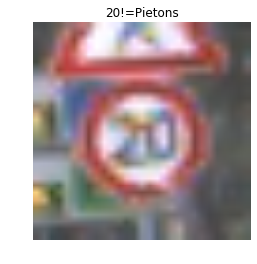

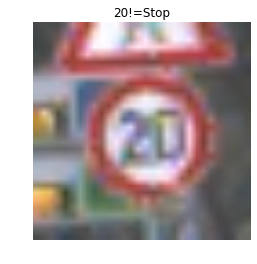

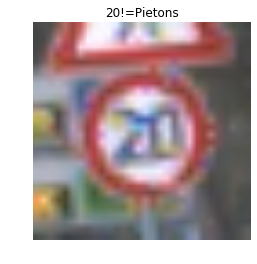

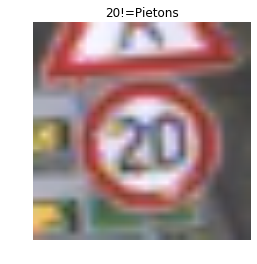

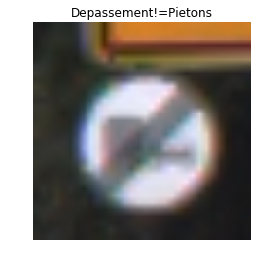

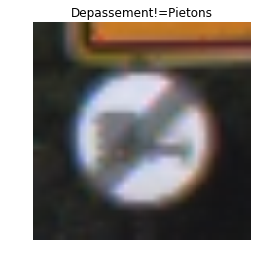

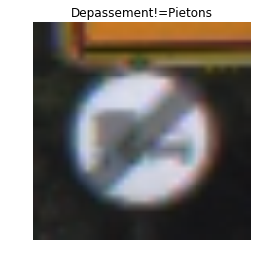

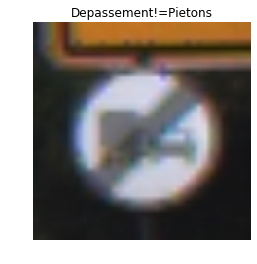

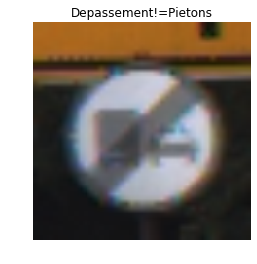